# Mean-variance optimization

In [102]:
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## Mean-variance efficient portfolio (two assets)

Define two risky assets and return of risk-free asset:

In [103]:
assets_df = pd.DataFrame({
  'R': [0.1355, 0.1497],
  'S': [0.1535, 0.2298]
}, index=['US', 'Japan'])
corr = 0.2663
r_rf = 0.05
r_us = assets_df.at['US', 'R']
r_jp = assets_df.at['Japan', 'R']
s_us = assets_df.at['US', 'S']
s_jp = assets_df.at['Japan', 'S']

assets_df

,R,S
US,0.1355,0.1535
Japan,0.1497,0.2298


Find the mean-variance efficient portfolio

In [104]:
def portolio_return(w1, w2, r1, r2):
    return w1*r1 + w2*r2

def portfolio_volatility(w1, w2, v1, v2, correlation):
    return ((w1**2)*(v1**2) + (w2**2)*(v2**2) + 2*w1*w2*v1*v2*correlation)**0.5

def sharpe_ratio(w, r1, r2, v1, v2, corr, rf):
    w1 = w
    w2 = 1 - w
    return (portolio_return(w1, w2, r1, r2) - rf)/portfolio_volatility(w1, w2, v1, v2, corr)

def find_mve(r1, r2, v1, v2, corr, rf):
    bounds = ((0, 1),)
    initial_guess = 0
    optimized_result = minimize(lambda x: -sharpe_ratio(x, r1, r2, v1, v2, corr, rf), 
    initial_guess, 
    method='SLSQP',
    bounds=bounds)
    return optimized_result.x[0]

w_us = find_mve(r_us, r_jp, s_us, s_jp, corr, r_rf)
w_jp = 1 - w_us
e_mve = portolio_return(w_us, w_jp, r_us, r_jp)
v_mve = portfolio_volatility(w_us, w_jp, s_us, s_jp, corr)

Construct data for capital allocation line

In [105]:
cal_df = pd.DataFrame({ 'w_mve': np.arange(0, 1.71, step=0.01) })
cal_df['w_rf'] = 1 - cal_df['w_mve']
cal_df['R'] = portolio_return(cal_df['w_mve'], cal_df['w_rf'], e_mve, r_rf)
cal_df['S'] = portfolio_volatility(cal_df['w_mve'], cal_df['w_rf'], v_mve, 0, 0)
cal_df['Sharpe ratio'] = (e_mve - r_rf)/v_mve
cal_df.tail()

,w_mve,w_rf,R,S,Sharpe ratio
166,1.66,-0.66,0.199042,0.236247,0.630873
167,1.67,-0.67,0.199940,0.237671,0.630873
168,1.68,-0.68,0.200838,0.239094,0.630873
169,1.69,-0.69,0.201736,0.240517,0.630873
170,1.70,-0.70,0.202633,0.241940,0.630873


Construct data for efficient frontier

In [106]:
ef_df = pd.DataFrame({ 'w_us': np.arange(0, 1.01, step=0.01) })
ef_df['w_jp'] = 1 - ef_df['w_us']
ef_df['R'] = portolio_return(ef_df['w_us'], ef_df['w_jp'], r_us, r_jp)
ef_df['S'] = portfolio_volatility(ef_df['w_us'], ef_df['w_jp'], s_us, s_jp, corr)
ef_df.head()

,w_us,w_jp,R,S
0,0.00,1.00,0.149700,0.229800
1,0.01,0.99,0.149558,0.227916
2,0.02,0.98,0.149416,0.226041
3,0.03,0.97,0.149274,0.224176
4,0.04,0.96,0.149132,0.222322


Plot the data

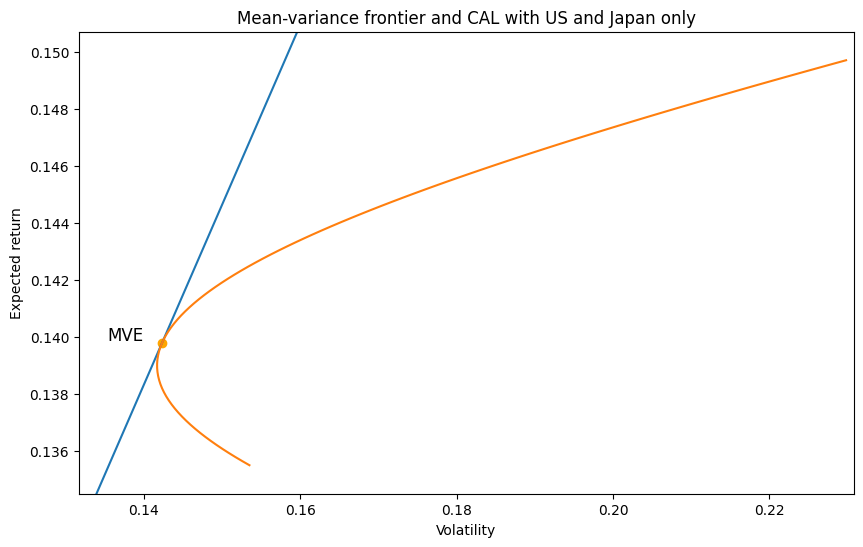

In [107]:
# Create the plot
fig, ax = plt.subplots(figsize=(10,6))

# plot capital allocation line
ax.plot(cal_df['S'], cal_df['R'])

# plot efficient frontier
ax.plot(ef_df['S'], ef_df['R'])

# plot mearn-variance efficient portfolio
ax.scatter(v_mve, e_mve, color='orange')
ax.text(v_mve-0.007, e_mve+0.0001, 'MVE', fontsize=12)

# add title and x/y-axis labels
plt.title('Mean-variance frontier and CAL with US and Japan only')
plt.xlabel('Volatility')
plt.ylabel('Expected return')

# Set the limits of axes
plt.ylim(ef_df['R'].min() - 0.001, ef_df['R'].max()+0.001)
plt.xlim(ef_df['S'].min() - 0.01, ef_df['S'].max()+0.001)

# Show the graph
plt.show()

plt.show()